In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import sys
import os

# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import RandomForestClassifier

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)


from src.models import (
    LogisticRegression, 
    MultinomialNB, 
)


from src.config import *
from src.data_processing import *



In [4]:
print("Đang nạp dữ liệu...")
INPUT = r'..\data\processed\sentiment_data.npz'
try:
    # Load file dữ liệu đã làm sạch
    data = np.load(INPUT, allow_pickle=True)
    X_text = data['X_text']
    y = data['y']
    print(f"[SUCCESS] Đã nạp thành công {len(X_text)} dòng dữ liệu.")
except FileNotFoundError:
    print("[ERROR] Không tìm thấy file 'sentiment_data.npz'. Đang tạo dữ liệu giả lập...")
    X_text = np.array([
        "vaccine is good and safe", "i hate side effects", "best protection ever", "terrible pain",
        "happy with the result", "scared of needles", "thank you science", "worst feeling ever"
    ] * 50)
    y = np.array([2, 0, 2, 0, 2, 0, 2, 0] * 50) # 0: Neg, 2: Pos

Đang nạp dữ liệu...
[SUCCESS] Đã nạp thành công 11020 dòng dữ liệu.


In [ ]:


# 1. Xử lý Stopwords (Giữ lại từ phủ định)
my_stop_words = list(ENGLISH_STOP_WORDS)
for w in NEGATION_WORDS:
    if w in my_stop_words:
        my_stop_words.remove(w)

# 2. Vector hóa
print("⏳ Đang vector hóa văn bản...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words=my_stop_words)
X_sparse = vectorizer.fit_transform(X_text) # Kết quả là ma trận thưa


# Các model tự viết dùng Numpy thuần nên cần bước này
print("⏳ Đang chuyển đổi sang Dense Array...")
X_dense = X_sparse.toarray()


# 3. Chia Train/Test
print("Đang chia tập dữ liệu 80-20...")
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y, test_size=0.2, random_state=42, stratify=y
)
print("Sẵn sàng huấn luyện!")

⏳ Đang vector hóa văn bản...
⏳ Đang chuyển đổi sang Dense Array...
Đang chia tập dữ liệu 80-20...
Sẵn sàng huấn luyện!


Model Name                | Accuracy  
----------------------------------------
Logistic Regression       | 74.18%
Naive Bayes               | 80.99%


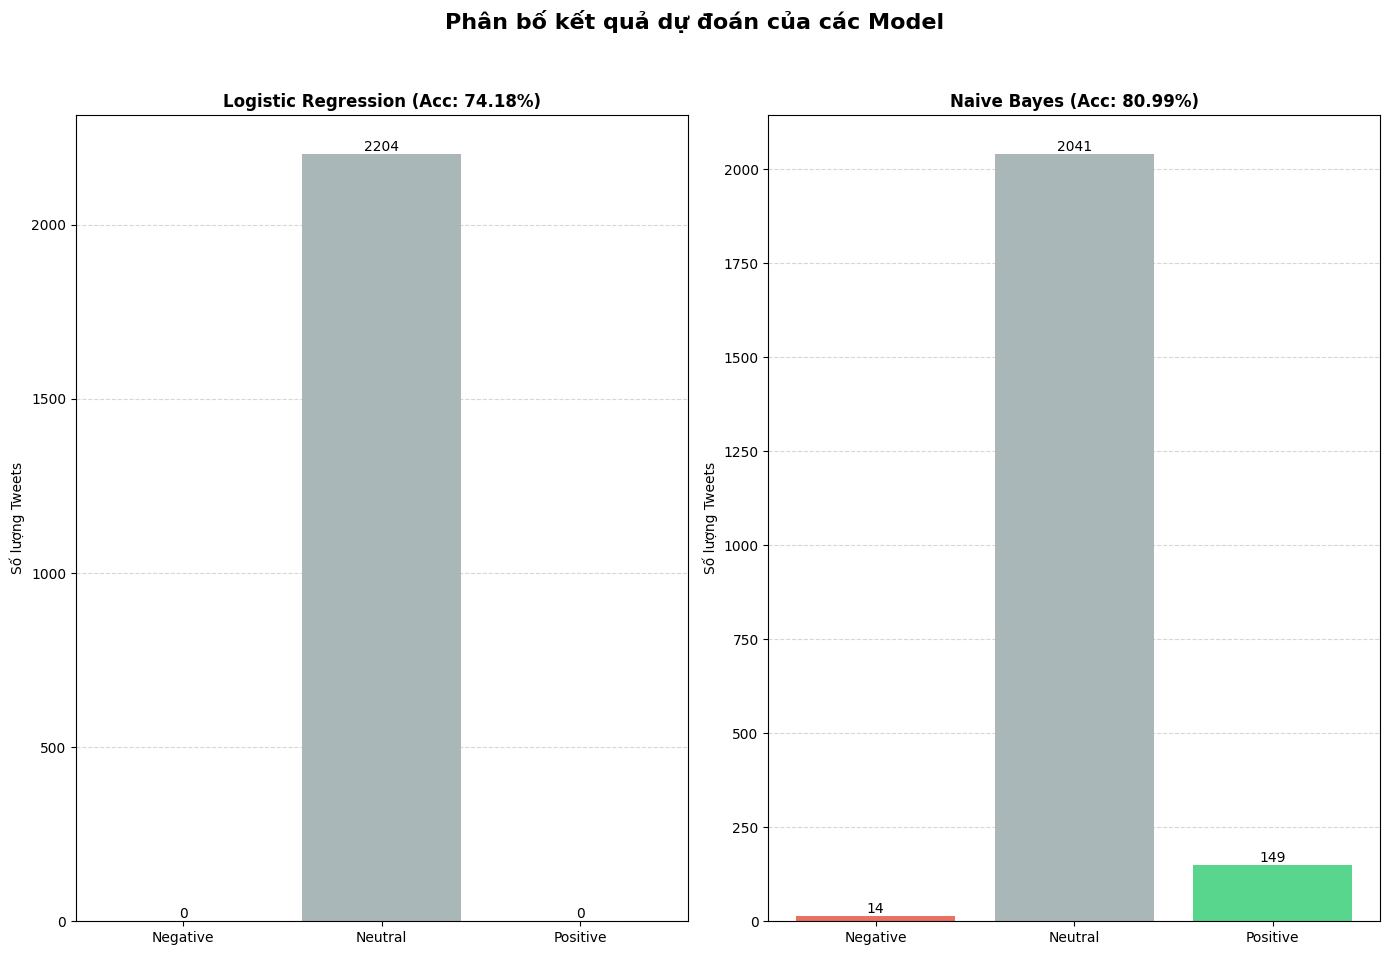

----------------------------------------
Mô hình tốt nhất: Naive Bayes


In [6]:
# Định nghĩa các mô hình
models = {
    # "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression": LogisticRegression(
        learning_rate=0.01, 
        n_iters=2000,
        lambda_param=0.01
    ),
    "Naive Bayes": MultinomialNB(),
    # "SVM (Linear SVC)": LinearSVC(n_iters=1000),
    # "Random Forest": RandomForestClassifier(n_trees=10, max_depth=10)
}

# Khởi tạo khung hình vẽ (Figure) với lưới 2x2 (cho 4 models)
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
fig.suptitle('Phân bố kết quả dự đoán của các Model', fontsize=16, fontweight='bold')
axes = axes.flatten() # Duỗi mảng 2 chiều thành 1 chiều để dễ truy cập trong vòng lặp

# Định nghĩa tên nhãn để hiển thị
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#e74c3c', '#95a5a6', '#2ecc71'] # Đỏ, Xám, Xanh

model_results = {}

print(f"{'Model Name':<25} | {'Accuracy':<10}")
print("-" * 40)

# Dùng enumerate để lấy cả chỉ số index (i) phục vụ việc chọn vị trí biểu đồ
for i, (name, model) in enumerate(models.items()):
    # 1. Train
    model.fit(X_train, y_train)
    
    # 2. Predict
    y_pred = model.predict(X_test)
    
    # 3. Score
    acc = accuracy_score(y_test, y_pred)
    model_results[name] = acc
    print(f"{name:<25} | {acc:.2%}")
    
    # 4. Xử lý dữ liệu vẽ biểu đồ (Không dùng Pandas)
    # Đếm số lượng từng nhãn (0, 1, 2)
    # minlength=3 đảm bảo nếu model không đoán ra nhãn nào thì số lượng vẫn là 0
    counts = np.bincount(y_pred, minlength=3) 
    
    # 5. Vẽ biểu đồ lên trục (axis) thứ i
    ax = axes[i]
    bars = ax.bar(label_names, counts, color=colors, alpha=0.8)
    
    # Trang trí biểu đồ
    ax.set_title(f"{name} (Acc: {acc:.2%})", fontweight='bold')
    ax.set_ylabel('Số lượng Tweets')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Hiển thị con số cụ thể trên đầu mỗi cột
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, 
                f'{count}', ha='center', va='bottom', fontsize=10)

# Tinh chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Chừa chỗ cho Title chính
plt.show()

# 6. Chọn model tốt nhất
best_model_name = max(model_results, key=model_results.get)
final_model = models[best_model_name]

print("-" * 40)
print(f"Mô hình tốt nhất: {best_model_name}")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3580\2722940470.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=accuracies, y=model_names, palette='viridis')


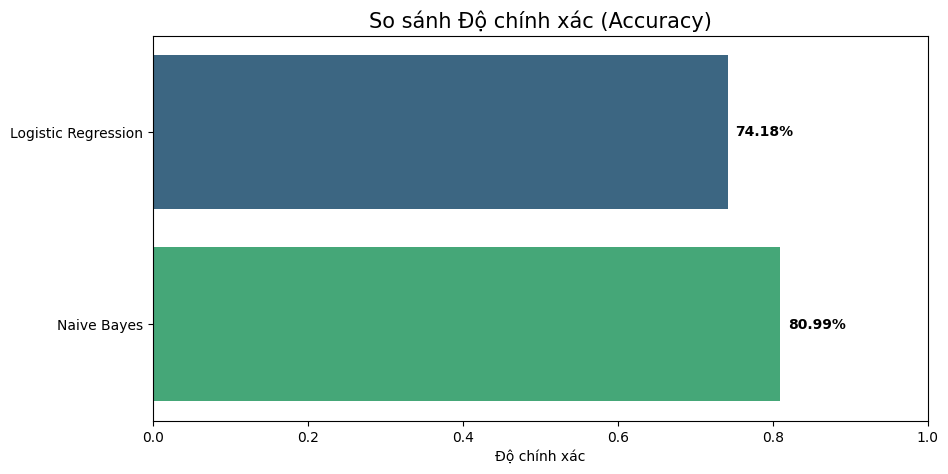

In [7]:
# Chuẩn bị dữ liệu cho biểu đồ từ Dictionary
model_names = list(model_results.keys())
accuracies = list(model_results.values())

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=accuracies, y=model_names, palette='viridis')

plt.title('So sánh Độ chính xác (Accuracy)', fontsize=15)
plt.xlabel('Độ chính xác')
plt.xlim(0, 1.0)

# Hiển thị số % trên cột
for i, v in enumerate(accuracies):
    ax.text(v + 0.01, i, f"{v:.2%}", va='center', fontweight='bold')

plt.show()

--- ĐÁNH GIÁ CHI TIẾT: NAIVE BAYES ---
              precision    recall  f1-score   support

    Negative       1.00      0.09      0.16       164
     Neutral       0.80      1.00      0.89      1635
    Positive       0.95      0.35      0.51       405

    accuracy                           0.81      2204
   macro avg       0.92      0.48      0.52      2204
weighted avg       0.84      0.81      0.76      2204



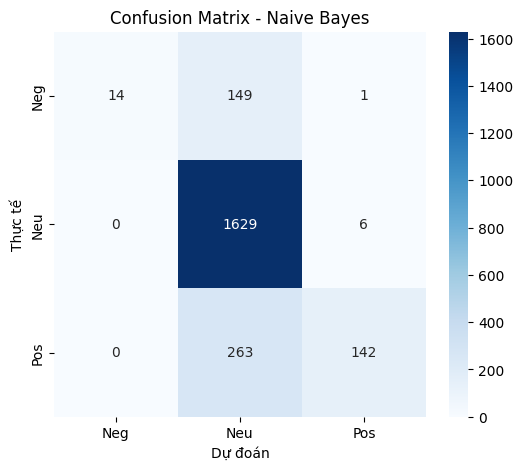

In [8]:
print(f"--- ĐÁNH GIÁ CHI TIẾT: {best_model_name.upper()} ---")

# Dự đoán lại trên tập test
y_pred_final = final_model.predict(X_test)

# Báo cáo chi tiết
print(classification_report(y_test, y_pred_final, target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

# Vẽ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Neg', 'Neu', 'Pos'], 
            yticklabels=['Neg', 'Neu', 'Pos'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [ ]:
def predict_sentiment(text):
    # 1. Làm sạch (dùng hàm ở Cell 1)
    cleaned = clean_text_advanced(text)
    
    # 2. Vector hóa (dùng vectorizer đã train ở Cell 2)
    vec_sparse = vectorizer.transform([cleaned]) # Kết quả là Sparse Matrix
    
    # --- SỬA LỖI Ở ĐÂY ---
    # Chuyển sang Dense Array để tương thích với model tự viết
    vec_dense = vec_sparse.toarray()
    
    # 3. Dự đoán (dùng final_model ở Cell 3)
    # Truyền vec_dense vào thay vì vec_sparse
    pred = final_model.predict(vec_dense)[0]
    
    mapper = {0: 'Tiêu cực', 1: 'Trung tính', 2: 'Tích cực'}
    return mapper[pred]


# --- TEST THỬ ---
print(f"Đang sử dụng mô hình: {best_model_name}\n")
samples = [
    "The vaccine is amazing and safe!",
    "I am scared of the side effects",
    "I got my second dose yesterday.",
    "It is not safe at all!",
    "No pain, feeling great"
]

for txt in samples:
    print(f"Input: {txt}")
    print(f"Label: {predict_sentiment(txt)}")
    print("-" * 30)

Đang sử dụng mô hình: Naive Bayes

Input: The vaccine is amazing and safe!
Label: Tích cực
------------------------------
Input: I am scared of the side effects
Label: Trung tính
------------------------------
Input: I got my second dose yesterday.
Label: Trung tính
------------------------------
Input: It is not safe at all!
Label: Tích cực
------------------------------
Input: No pain, feeling great
Label: Tích cực
------------------------------
